In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopandas as gpd
from shapely import wkt
import geopandas as gpd
import contextily as ctx
import matplotlib.lines as mlines
#deactivate warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Load data
df = pd.read_csv('../data/processed/processed_road_segments.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
#transform into geodataframe
gdf = gpd.GeoDataFrame(df, geometry='geometry')
water_df = pd.read_excel('../data/raw/flood_data/geolocations_stations.xlsx')

<h1>EDA</h1>

<h2>Average Traffic Volume per Mode of Transport</h2>

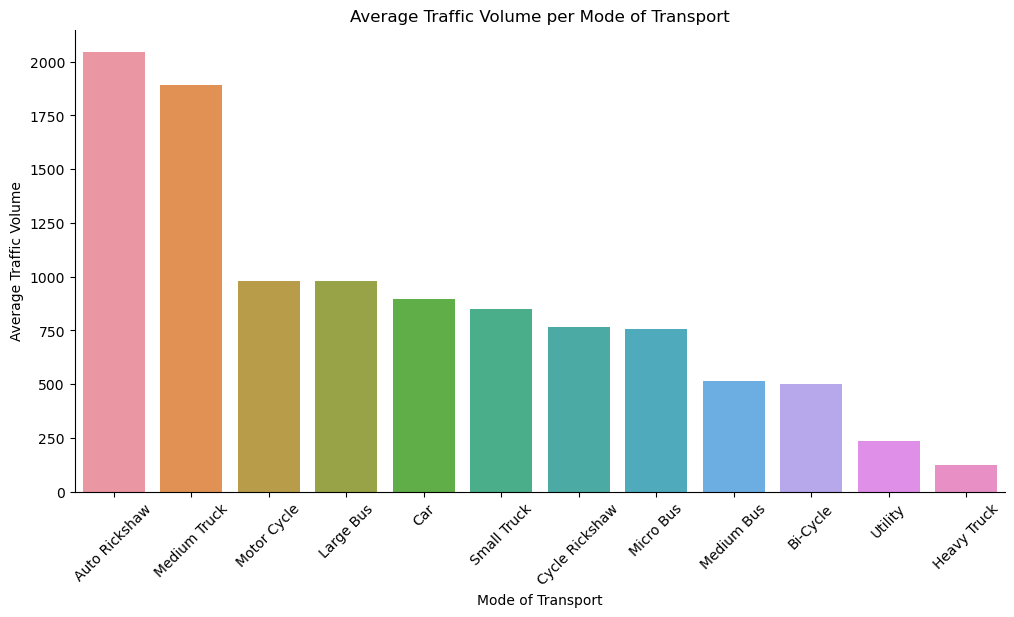

In [3]:
# List of modes of transport in your dataset
transport_modes = ['Heavy Truck', 'Medium Truck', 'Small Truck', 'Large Bus', 'Medium Bus', 'Micro Bus', 'Utility', 'Car', 'Auto Rickshaw', 'Motor Cycle', 'Bi-Cycle', 'Cycle Rickshaw']

# Calculate the average for each mode of transport
averages = df[transport_modes].mean()
# Sort the averages in descending order
averages = averages.sort_values(ascending=False)

# Create a bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=averages.index, y=averages.values)
plt.xticks(rotation=45)
plt.title('Average Traffic Volume per Mode of Transport')
plt.xlabel('Mode of Transport')
plt.ylabel('Average Traffic Volume')
#remove top and right border
sns.despine()
plt.show()

<h2>Correlation</h2>

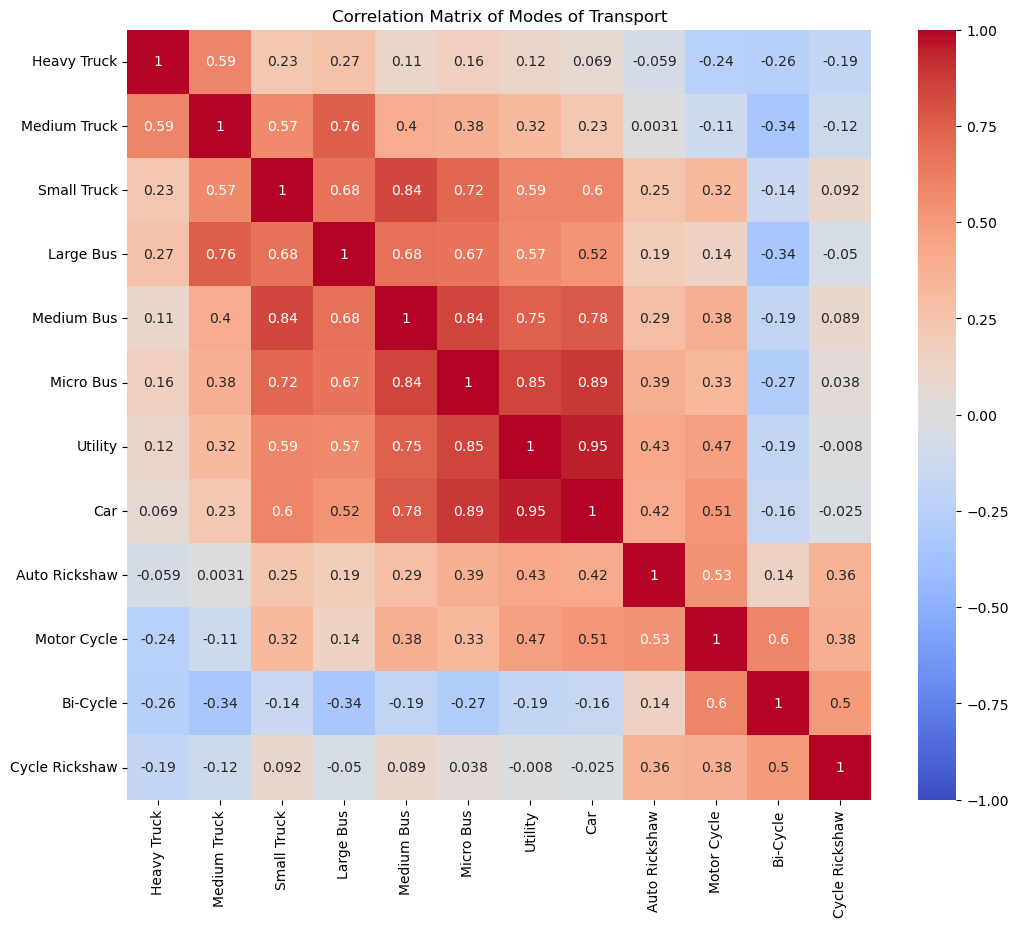

Strong correlations between vehicle types:
   Vehicle Type 1 Vehicle Type 2  Correlation
3     Small Truck     Medium Bus     0.841290
5      Medium Bus    Small Truck     0.841290
7      Medium Bus      Micro Bus     0.843803
8       Micro Bus     Medium Bus     0.843803
10      Micro Bus        Utility     0.848482
11      Micro Bus            Car     0.890319
12        Utility      Micro Bus     0.848482
14        Utility            Car     0.952634
15            Car      Micro Bus     0.890319
16            Car        Utility     0.952634
Negative correlations between vehicle types:
  Vehicle Type 1 Vehicle Type 2  Correlation
0    Heavy Truck    Motor Cycle    -0.242809
1    Heavy Truck       Bi-Cycle    -0.257478
2   Medium Truck       Bi-Cycle    -0.343687
3      Large Bus       Bi-Cycle    -0.335928
4      Micro Bus       Bi-Cycle    -0.273936
5    Motor Cycle    Heavy Truck    -0.242809
6       Bi-Cycle    Heavy Truck    -0.257478
7       Bi-Cycle   Medium Truck    -0.343687
8

In [4]:
# Calculate the correlation matrix
corr_matrix = df[transport_modes].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Modes of Transport')
plt.show()

# Investigate strong correlations
strong_corr_threshold = 0.8
strong_correlations = corr_matrix[(corr_matrix >= strong_corr_threshold) | (corr_matrix <= -strong_corr_threshold)].stack().reset_index()
strong_correlations.columns = ['Vehicle Type 1', 'Vehicle Type 2', 'Correlation']
strong_correlations = strong_correlations.query('`Vehicle Type 1` != `Vehicle Type 2`')
print("Strong correlations between vehicle types:")
print(strong_correlations)
#Investigate negative correlations
negative_correlations = corr_matrix[(corr_matrix < -0.2)].stack().reset_index()
negative_correlations.columns = ['Vehicle Type 1', 'Vehicle Type 2', 'Correlation']
negative_correlations = negative_correlations.query('`Vehicle Type 1` != `Vehicle Type 2`')
print("Negative correlations between vehicle types:")
print(negative_correlations)


<h3>Busiest Roads </h3>

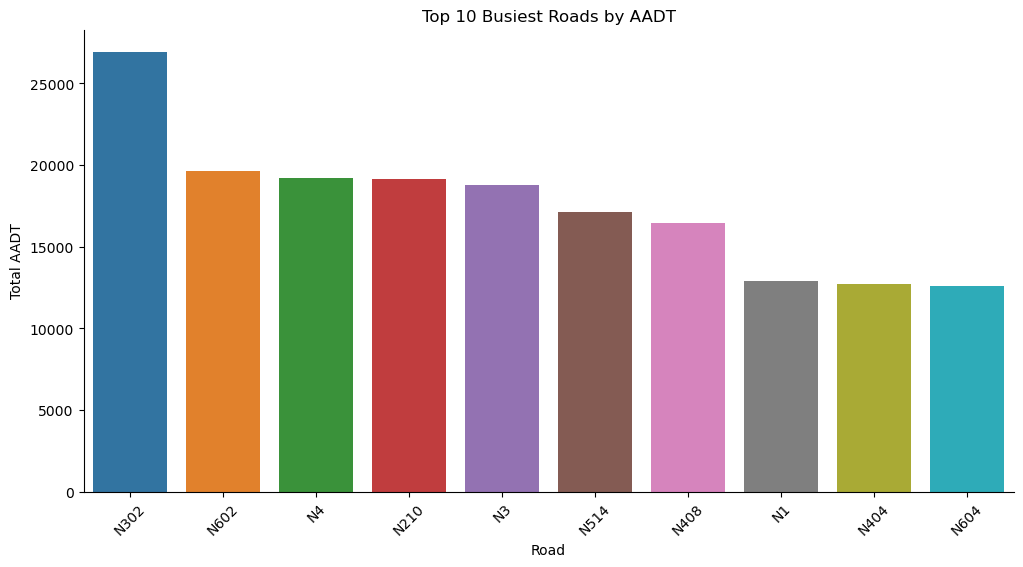

In [5]:
#group by road name
grouped_df = df.groupby('road_name')['Total AADT'].mean().reset_index()

# Sort roads by total AADT
grouped_df_sorted = grouped_df.sort_values(by='Total AADT', ascending=False)

# Select the top 10 busiest roads
top_10_roads = grouped_df_sorted.head(10)

# Create a bar plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='road_name', y='Total AADT', data=top_10_roads)
plt.title('Top 10 Busiest Roads by AADT')
plt.xlabel('Road')
plt.ylabel('Total AADT')
plt.xticks(rotation=45)
#remove top and right border
sns.despine()
plt.show()

<h2>Geospatial Visualization</h2>

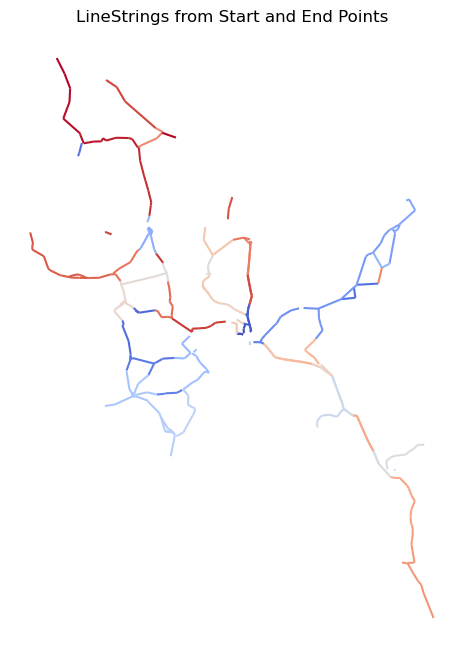

In [6]:
# Visualize the GeoDataFrame
ax = gdf.plot(figsize=(12, 8), cmap='coolwarm', legend=True)
ax.set_title('LineStrings from Start and End Points')
ax.set_axis_off()
plt.show()

<h3>Medium Truck Volume per Road Segment</h3>

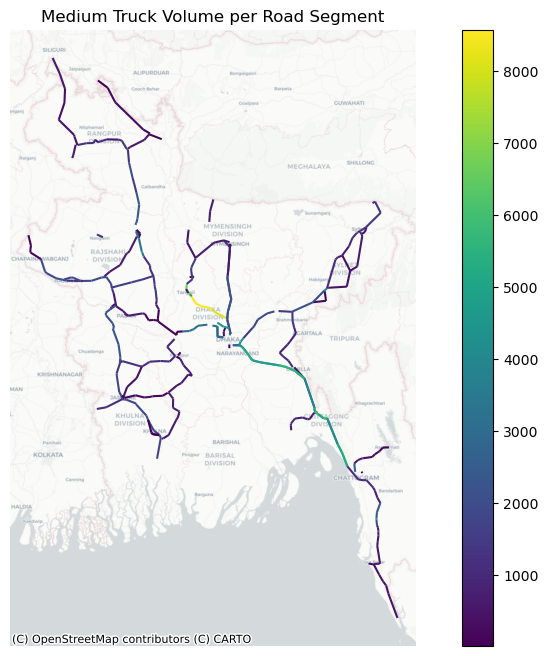

In [7]:
#Set CRS
gdf.crs = "EPSG:4326"
gdf_web_mercator = gdf.to_crs("EPSG:3857")
# Visualize the GeoDataFrame
fig, ax = plt.subplots(figsize=(12, 8))
gdf_web_mercator.plot(column='Medium Truck', cmap='viridis', legend=True, ax=ax)
#Set background map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Medium Truck Volume per Road Segment')
ax.set_axis_off()
plt.show()

<h3>Auto Rickshaw Volume per Road Segment</h3>

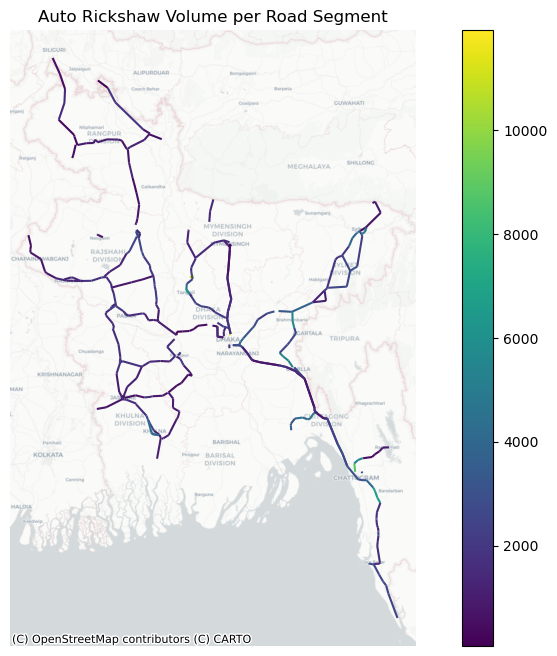

In [8]:
#Initialize figure
fig, ax = plt.subplots(figsize=(12, 8))
gdf_web_mercator.plot(column='Auto Rickshaw', cmap='viridis', legend=True, ax=ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title('Auto Rickshaw Volume per Road Segment')
ax.set_axis_off()
plt.show()

<h1>Criticality</h1>

<h2>Top 10 most critical road segments </h2>

In [9]:
#sort by criticality
df = df.sort_values(by=['criticality_index'], ascending=False)

In [10]:
#show top 10 critical roads with total tonnage and criticality index
df[['link_no', 'weighted_total_tonnage', 'criticality_index']].head(10)

,link_no,weighted_total_tonnage,criticality_index
248,N106-1,3.588033,1.000000
8,N3-1R,2.566915,0.714761
7,N3-1L,2.415220,0.672386
10,N3-2R,2.407126,0.670125
68,N2-1,2.201797,0.612769
303,N5-3L,1.999468,0.556250
69,N2-2,1.995565,0.555160
70,N2-3,1.926431,0.535848
71,N2-4,1.926431,0.535848
430,N6-14,1.904743,0.529789


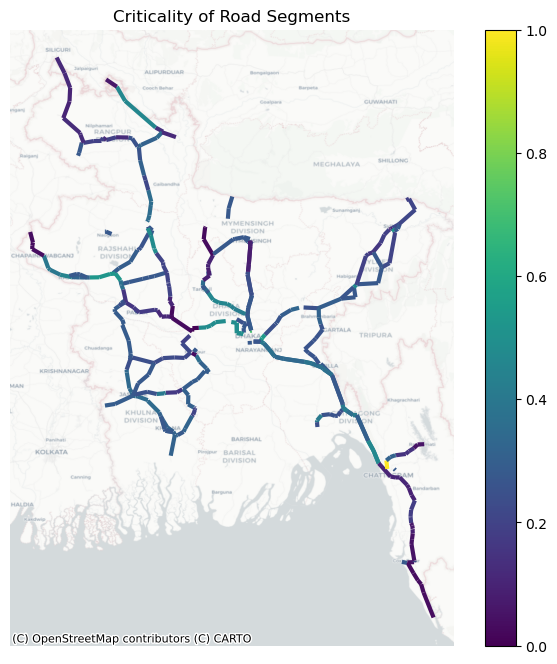

In [11]:
#Initialize figure
fig, ax = plt.subplots(figsize=(8, 8))

gdf.plot(column='criticality_index', cmap='viridis', legend=True, ax=ax,linewidth=3)
#Add Basemap
ctx.add_basemap(ax=ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

ax.set_title('Criticality of Road Segments')
ax.set_axis_off()
plt.show()

<h1>Vulnerability</h1>

<h2>Top 10 most vulnerable road segments </h2>

In [12]:
#check water station data
water_df.head()

,Station Name,River Name,Division,District,Upazilla,Union,Average Land Level,Water Level,Unnamed: 8,Highest Water Level,Danger Level,Longitude,Latitude
0,Chiringa,Matamuhuri,Chittagong,Cox's Bazar,Chakaria,Baraitali,NaN,4.48,,7.03,5.80,92.079743,21.773552
1,Lama,Matamuhuri,Chittagong,Cox's Bazar,Chakaria,Kakhara,NaN,8.68,,15.46,12.25,92.209356,21.793554
2,Patherghata,Bishkhali River,Barisal,Barguna,Patharghata,Kalmegha,NaN,8.68,,3.80,1.85,89.987211,22.050923
3,Dohazari,Sangu,Chittagong,Chittagong,Chandanaish,Hashimpur,NaN,4.98,,9.05,7.00,92.063472,22.157910
4,Dasmunia,Tentulia,Barisal,Patuakhali,Dashmina,Rangopaldi,NaN,4.98,,NaN,2.59,90.548604,22.230833


In [13]:
water_gdf = gpd.GeoDataFrame(water_df, geometry=gpd.points_from_xy(water_df['Longitude '], water_df['Latitude ']))

In [14]:
def excess_water(segment):
    """calculate excess water in a segment
    
    Parameters
    ----------
    segment : pandas.Series
        a row of the dataframe containing the segment information
    Returns
    -------
    float
        excess water in the segment
    """
    
    if math.isnan(segment['Highest Water Level']):
        return segment['Water Level ']-segment['Danger Level ']
    else:
        return segment['Highest Water Level']-segment['Danger Level ']



In [15]:
#calculate excess water
water_gdf['Excess Water Level'] = water_gdf.apply(excess_water,axis=1)

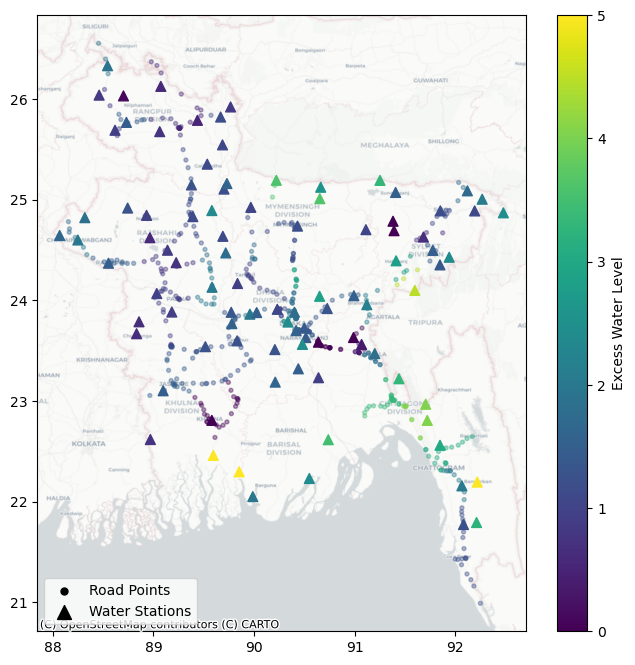

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

# Extract the 'Excess Water Level' column from the data frames
water_levels = water_gdf['Excess Water Level']
road_levels = df['Excess Water Level']

# Plot the scatter points with the 'Excess Water Level' column as the color
sc = ax.scatter(data=water_gdf, x="Longitude ", y="Latitude ", marker="^", alpha=1, s=50, vmin=0, vmax=5, c=water_levels, cmap="viridis")
sc2 = ax.scatter(data=df, x="lon_mid", y="lat_mid", alpha=0.4, s=8, vmin=0, vmax=5, c=road_levels, cmap="viridis")

# Add a basemap to the plot
ctx.add_basemap(ax=ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)

# Add a colorbar to the plot
cbar = plt.colorbar(sc)
cbar.set_label("Excess Water Level")

# Create legend handles
black_circle = plt.scatter([], [], color="black", marker=".", s=100, label="Road Points")
black_triangle = plt.scatter([], [], color="black", marker="^", s=100, label="Water Stations")

# Add legend to the plot
ax.legend(handles=[black_circle, black_triangle], loc="lower left")

plt.show()

In [17]:
#sort by vulnerability_index
df = df.sort_values(by=['vulnerability_index'], ascending=False)

In [18]:
#show top 10 vulnerable roads with sensitivity, exposure, adaptive capacity and vulnerability index
df[['link_no', 'sensitivity_normalized', 'exposure_normalized', 'adaptive_capacity_normalized', 'vulnerability_index']].head(10)

,link_no,sensitivity_normalized,exposure_normalized,adaptive_capacity_normalized,vulnerability_index
388,N1-68,1.000000,0.595268,0.023978,0.539749
377,N1-57,0.648063,0.595268,0.288610,0.510647
326,N1-11L,0.166705,0.351183,1.000000,0.505963
87,N2-13,0.620198,0.709838,0.026227,0.452087
437,N5-17,0.517063,0.697385,0.121839,0.445429
250,N106-3,0.475535,0.820672,0.018782,0.438330
320,N1-8L,0.458551,0.620174,0.233160,0.437295
249,N106-2,0.447123,0.820672,0.029584,0.432460
85,N2-11,0.130621,0.632628,0.530146,0.431131
25,N302-3,0.541087,0.661270,0.090233,0.430863


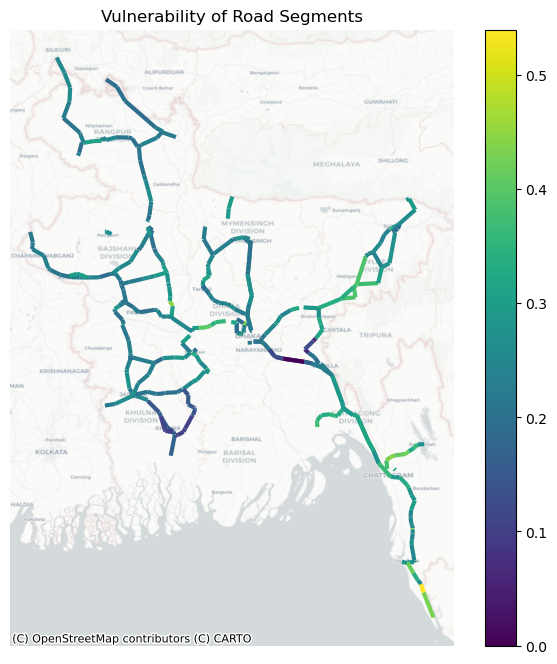

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
#plot
gdf.plot(column='vulnerability_index', cmap='viridis', legend=True, ax=ax,linewidth=3)
#add basemap
ctx.add_basemap(ax=ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)
ax.set_title('Vulnerability of Road Segments')
ax.set_axis_off()
plt.show()

<h1>Importance</h1>

<h2>Top 10 most important road segments</h2>

In [20]:
#sort by importance_index
df = df.sort_values(by=['importance_index'], ascending=False)

In [21]:
#show top 10 important roads with  criticality index, vulnerability index and importance index
df[['link_no', 'criticality_index', 'vulnerability_index', 'importance_index']].head(10)

,link_no,criticality_index,vulnerability_index,importance_index
248,N106-1,1.000000,0.376794,0.688397
8,N3-1R,0.714761,0.220423,0.467592
7,N3-1L,0.672386,0.253423,0.462905
71,N2-4,0.535848,0.389208,0.462528
10,N3-2R,0.670125,0.220423,0.445274
68,N2-1,0.612769,0.275991,0.444380
479,N5-9,0.484151,0.402073,0.443112
478,N5-8,0.484151,0.401456,0.442804
326,N1-11L,0.372744,0.505963,0.439353
3,N5-2L,0.475310,0.397011,0.436161


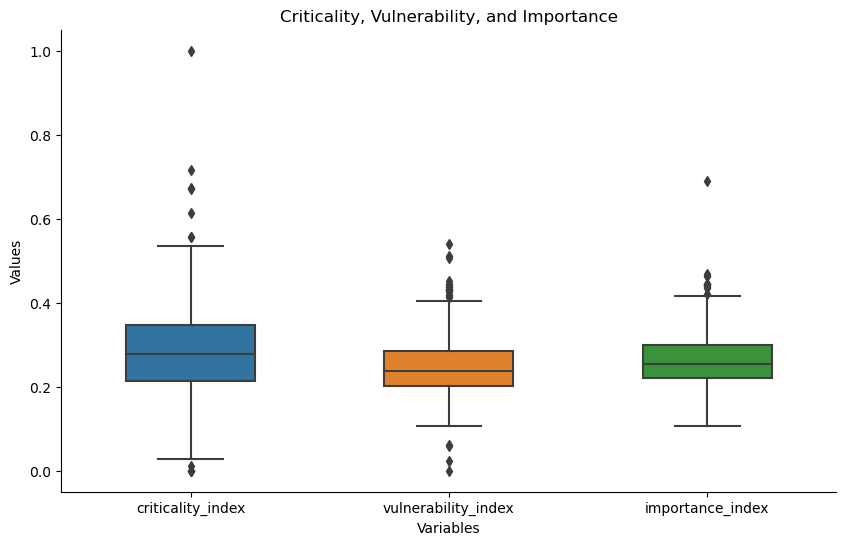

In [22]:
columns_to_plot = ['criticality_index', 'vulnerability_index','importance_index']


# Create a boxplot with seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[columns_to_plot], width=0.5)
plt.title('Criticality, Vulnerability, and Importance')
plt.xlabel('Variables')
#despine
sns.despine()
plt.ylabel('Values')
plt.show()

In [23]:
#statistics of importance
df['importance_index'].describe()

count    513.000000
mean       0.262911
std        0.070258
min        0.106685
25%        0.221423
50%        0.254655
75%        0.300153
max        0.688397
Name: importance_index, dtype: float64

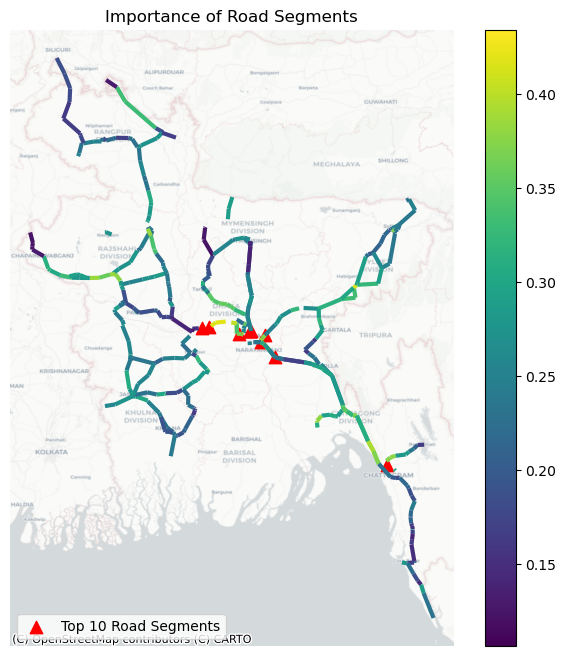

In [24]:
df = df.sort_values(by=['importance_index'], ascending=False)
#top 10 important roads
top_10_importance_index = df[['link_no', 'criticality_index', 'vulnerability_index', 'importance_index','lat_mid','lon_mid']].head(10)
#top_10_importance_index to gdf
top_10_importance_index = gpd.GeoDataFrame(top_10_importance_index, geometry=gpd.points_from_xy(top_10_importance_index['lon_mid'], top_10_importance_index['lat_mid']))
#set crs
top_10_importance_index.crs = "EPSG:4326"
top_10_importance_index = top_10_importance_index.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))

#highlight if in top 10
gdf['highlight'] = gdf['link_no'].isin(top_10_importance_index['link_no'])
#set highlight style
highlight_style = dict(color='red', edgecolor='black', linewidth=1, alpha=0.7, zorder=3)
#plot non highlighted roads
gdf[gdf['highlight'] == False].plot(column='importance_index', cmap='viridis', legend=True, ax=ax,linewidth=3)

sc = ax.scatter(data=top_10_importance_index, x="lon_mid", y="lat_mid", marker="^", alpha=1, s=80, color='red', label="Top 10 Road Segments")
#add basemap
ctx.add_basemap(ax=ax, crs="EPSG:4326", source=ctx.providers.CartoDB.Positron)
ax.legend(handles=[sc], loc="lower left")
ax.set_title('Importance of Road Segments')
ax.set_axis_off()
plt.show()

<h1>Bridges</h1>

In [25]:
bridges = pd.read_csv('../data/processed/bridges_with_traffic.csv')

In [26]:
#find bridges of segmenets with highest importance index
bridges_top_10 = bridges[bridges['link_no'].isin(top_10_importance_index['link_no'])]


In [27]:
#add importance index to bridge
bridges_top_10 = bridges_top_10.merge(top_10_importance_index[['link_no','importance_index']], on='link_no', how='left')

In [28]:
#sort by importance index
bridges_top_10 = bridges_top_10.sort_values(by=['importance_index'], ascending=False)
#bridges for N106-1
bridges_n106_1 = bridges_top_10[bridges_top_10['link_no'] == 'N106-1']


In [29]:
# Define a dictionary to map condition values to weight factors
condition_weight = {'D': 1, 'C': 0.71, 'B': 0.44, 'A': 0.19}

# Use replace() to map condition values to weight factors
bridges_n106_1['condition_weighted'] = bridges_n106_1['condition'].replace(condition_weight)

# Calculate the weighted length of each bridge
bridges_n106_1['length_weighted'] = bridges_n106_1['length'] * bridges_n106_1['condition_weighted']

In [30]:
#sort by length_weighted
bridges_n106_1 = bridges_n106_1.sort_values(by=['length_weighted'], ascending=False)
#show length, and condition
bridges_n106_1[['name_x','length', 'condition', 'condition_weighted', 'length_weighted']].head(10)

,name_x,length,condition,condition_weighted,length_weighted
58,Natunpara Bridge,18.78,C,0.71,13.3338
38,NOTUN PARA,17.60,B,0.44,7.7440
64,DAWANNAGOR CULVERT,9.50,C,0.71,6.7450
61,BORODIGHIR PAR,8.80,C,0.71,6.2480
62,CHOWDIRIR HAT,6.00,C,0.71,4.2600
39,PASSIM SURAGOL,9.40,B,0.44,4.1360
60,BORDIGHIR PAR,4.50,C,0.71,3.1950
63,11 MILE BOX CULVERT,3.80,C,0.71,2.6980
16,Modarhat Bridge,13.20,A,0.19,2.5080
59,LALIYAR HAT,3.30,C,0.71,2.3430
